In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d, gaussian_filter  # Updated import statements
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, fbeta_score, precision_recall_curve,
    average_precision_score, auc
)


In [2]:
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
    BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
from inspect import signature


In [5]:
def detrender_normalizer(light_flux):
  flux1 = light_flux
  flux2 = gaussian_filter(flux1, sigma=10)
  flux3 = flux1 - flux2
  flux3normalized = (flux3-np.mean(flux3)) / (np.max(flux3)-np.min(flux3))
  return flux3normalized

In [9]:
#Define a function for shuffeling in unison
def shuffle_in_unison(a, b):
  rng_state = np.random.get_state()
  np.random.shuffle(a)
  np.random.set_state(rng_state)
  np.random.shuffle(b)

In [10]:
def batch_generator(x_train, y_train, batch_size=32):
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32') #empty matrix for input
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32') #empty matrix for output

    # Find indicies for positive and negative labels
    while True:
        pos_idx = np.where(y_train[:,0] == 1)[0]
        neg_idx = np.where(y_train[:,0] == 0)[0]

        # Randomize the positive and negative indicies
        np.random.shuffle(pos_idx)
        np.random.shuffle(neg_idx)

        # Let half of the batch have a positive classification and the other
        # half have a negative classification
        x_batch[:half_batch] = x_train[pos_idx[:half_batch]]
        x_batch[half_batch:] = x_train[neg_idx[half_batch:batch_size]] 
        y_batch[:half_batch] = y_train[pos_idx[:half_batch]]
        y_batch[half_batch:] = y_train[neg_idx[half_batch:batch_size]]

        # Shuffle batch
        shuffle_in_unison(x_batch,y_batch)

        # Generating new examples by rotating them in time
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
        yield x_batch, y_batch

Loading datasets...
Constructing The Neural Networks...
Epoch 1/50
160/160 - 6s - loss: 0.7031 - accuracy: 0.5576 - val_loss: 0.5388 - val_accuracy: 0.8383 - 6s/epoch - 40ms/step
Epoch 2/50
160/160 - 4s - loss: 0.6698 - accuracy: 0.5914 - val_loss: 0.5327 - val_accuracy: 0.8122 - 4s/epoch - 24ms/step
Epoch 3/50
160/160 - 4s - loss: 0.6593 - accuracy: 0.6086 - val_loss: 0.5205 - val_accuracy: 0.8104 - 4s/epoch - 25ms/step
Epoch 4/50
160/160 - 4s - loss: 0.6396 - accuracy: 0.6271 - val_loss: 0.5062 - val_accuracy: 0.7965 - 4s/epoch - 25ms/step
Epoch 5/50
160/160 - 4s - loss: 0.6179 - accuracy: 0.6508 - val_loss: 0.5037 - val_accuracy: 0.7930 - 4s/epoch - 26ms/step
Epoch 6/50
160/160 - 4s - loss: 0.6013 - accuracy: 0.6730 - val_loss: 0.4851 - val_accuracy: 0.7948 - 4s/epoch - 27ms/step
Epoch 7/50
160/160 - 4s - loss: 0.5955 - accuracy: 0.6816 - val_loss: 0.4855 - val_accuracy: 0.7757 - 4s/epoch - 27ms/step
Epoch 8/50
160/160 - 4s - loss: 0.5656 - accuracy: 0.7141 - val_loss: 0.4848 - val_

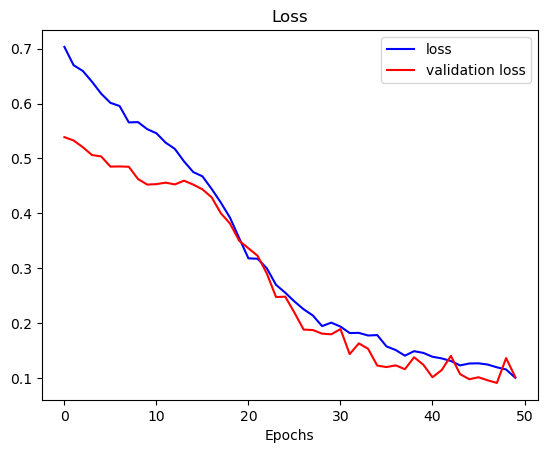

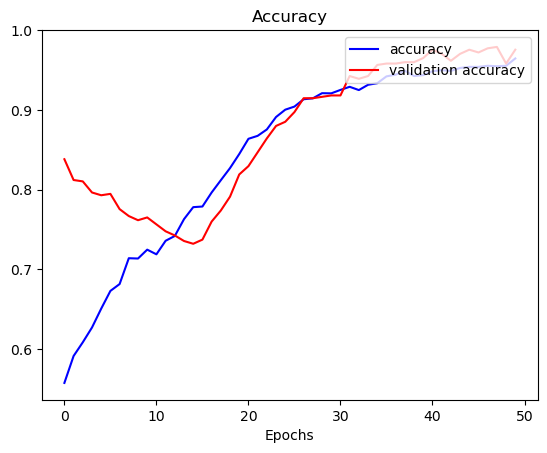

161/161 [==============================] - 1s 8ms/step
Validation for training data:
col_0     0    1
row_0           
0      4838  212
1         0   74
Accuracy: 0.959 Precision: 0.259 Recall: 1.000 F_beta: 0.411
Area under precision-recall-curve: 0.708


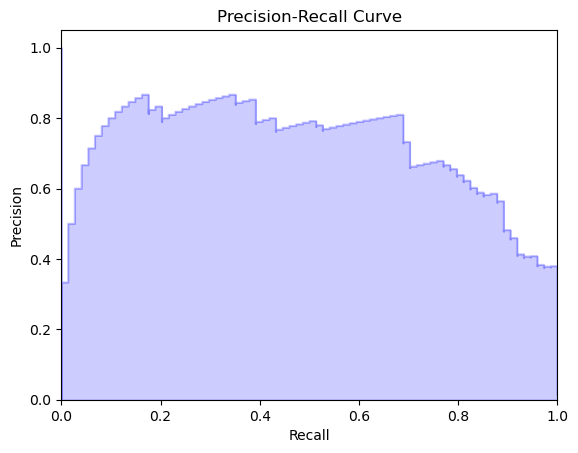

18/18 [==============================] - 0s 8ms/step
Validation for test data:
col_0    0   1
row_0         
0      551  14
1        0  10
Accuracy: 0.976 Precision: 0.417 Recall: 1.000 F_beta: 0.588
Area under precision-recall-curve: 0.664


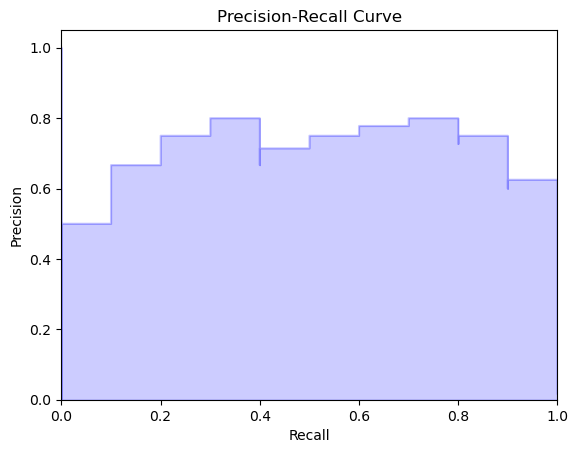

In [23]:
def main():
    # Converting the format from a dataframe to numpy arrays (matrices)
    # and defining x-values and y-values for both the test and training set
    print("Loading datasets...")
    train = pd.read_csv("Data/exoTrain.csv", encoding="ISO-8859-1")  # in dataframe format
    test = pd.read_csv("Data/exoTest.csv", encoding="ISO-8859-1")  # in dataframe format
    x_train = train.drop('LABEL', axis=1)
    x_test = test.drop('LABEL', axis=1)
    y_train = train.LABEL
    y_test = test.LABEL
    x_train = np.array(x_train)
    y_train = np.array(y_train).reshape((-1, 1)) - 1
    x_test = np.array(x_test)
    y_test = np.array(y_test).reshape((-1, 1)) - 1

    # Add extra positive examples of light curves by flipping them ( Data Augmentation )
    x_train = np.append(x_train, np.flip(x_train[0:37, :], axis=-1), axis=0)
    y_train = np.append(y_train, y_train[0:37]).reshape((-1, 1))
    x_test = np.append(x_test, np.flip(x_test[0:5, :], axis=-1), axis=0)
    y_test = np.append(y_test, y_test[0:5]).reshape((-1, 1))

    # Detrend the data sets
    x_train_p = detrender_normalizer(x_train)
    x_test_p = detrender_normalizer(x_test)

    # Scale each observation to zero mean and unit variance
    x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1, 1)) / np.std(x_train, axis=1).reshape(-1, 1))
    x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1, 1)) / np.std(x_test, axis=1).reshape(-1, 1))

    # Stack the zero mean unit variance normalized data and the detrended data
    x_train = np.stack([x_train, x_train_p], axis=2)
    x_test = np.stack([x_test, x_test_p], axis=2)

    print("Constructing The Neural Networks...")
    # Construct the neural network
    model = Sequential()
    model.add(Conv1D(filters=8, kernel_size=11, activation='linear', input_shape=x_train.shape[1:]))
    model.add(MaxPool1D(strides=4))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
    model.add(MaxPool1D(strides=4))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
    model.add(MaxPool1D(strides=4))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
    model.add(MaxPool1D(strides=4))
    model.add(Flatten())
    model.add(Dropout(0.5))  # prevents overfitting
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))  # prevents overfitting
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model and train the model, make sure it converges
    model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    hist = model.fit_generator(batch_generator(x_train, y_train, 32),
                               validation_data=(x_test, y_test),
                               verbose=0, epochs=5,
                               steps_per_epoch=x_train.shape[0] // 32)

    # Proceeding the training with a faster learning rate
    model.compile(optimizer=Adam(4e-5), loss='binary_crossentropy', metrics=['accuracy'])
    hist = model.fit_generator(batch_generator(x_train, y_train, 32),
                              validation_data=(x_test, y_test),
                              verbose=2, epochs=50,
                              steps_per_epoch=x_train.shape[0] // 32)

    # Saving model to JSON and weights to HDF5
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("model.h5")
    print("Saved model to disk")
    # Plot the loss and accuracy for the training
    plt.plot(hist.history['loss'], color='b', label='loss')
    plt.plot(hist.history['val_loss'], color='r', label='validation loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')
    plt.show()
    plt.plot(hist.history['accuracy'], color='b', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='r', label='validation accuracy')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')
    plt.show()

    # Make predictions for training data
    shuffle_in_unison(x_train, y_train)
    y_pred = model.predict(x_train)[:, 0]
    pred = np.empty((1, len(y_pred)), dtype=object)
    pred = np.where(y_pred >= 0.5, 1, 0)
    y_train = np.reshape(y_train, len(y_train))
    pred = np.reshape(pred, len(pred))

    # Create confusion matrix for training data
    print('Validation for training data:')
    conf_matrix = pd.crosstab(y_train, pred)
    print(conf_matrix)

    # Calculate precision and recall
    accuracy = accuracy_score(y_train, pred)
    precision = precision_score(y_train, pred)
    recall = recall_score(y_train, pred)
    fbeta = fbeta_score(y_train, pred, beta=1)
    print('Accuracy: %.3f Precision: %.3f Recall: %.3f F_beta: %.3f' % (accuracy, precision, recall, fbeta))

    # Create a precision recall curve
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred, pos_label=1)
    auc_pr = auc(recall, precision)
    print('Area under precision-recall-curve: %.3f' % (auc_pr))
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()

    # Make predictions for test data
    shuffle_in_unison(x_test, y_test)
    y_pred = model.predict(x_test)[:, 0]
    pred = np.empty((1, len(y_pred)), dtype=object)
    pred = np.where(y_pred >= 0.5, 1, 0)
    y_test = np.reshape(y_test, len(y_test))
    pred = np.reshape(pred, len(pred))

    # Create confusion matrix for test data
    print('Validation for test data:')
    conf_matrix = pd.crosstab(y_test, pred)
    print(conf_matrix)

    # Calculate precision and recall
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    fbeta = fbeta_score(y_test, pred, beta=1)
    print('Accuracy: %.3f Precision: %.3f Recall: %.3f F_beta: %.3f' % (accuracy, precision, recall, fbeta))

    # Create a precision recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred, pos_label=1)
    auc_pr = auc(recall, precision)
    print('Area under precision-recall-curve: %.3f' % (auc_pr))
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()

main()
